In [1]:
library(forecast)
library(tsutils)
library(lubridate)
library(xts)
library(tsbox)

#data <- read.csv('covid_case_distribution.csv')
#data <- read.csv('covid_cases_26_12_2020.csv')
data <- read.csv('owid-covid-data.csv')
# Samo podaci za HRV, najkasnije do 6.11.
#data <- data[data$countriesAndTerritories == 'Croatia',]
data <- data[data$location == 'Croatia',]
data <- data[order(as.Date(data$date, '%d-%m-%Y')),]
train_data <- data[(data$date <= as.Date('06-11-2020', '%d-%m-%Y')),]
test_data <- data[(data$date > as.Date('06-11-2020', '%d-%m-%Y')),]

row.names(data) <- NULL

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




   iso_code          continent           location             date          
 Length:305         Length:305         Length:305         Length:305        
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                                            
                                                                            
  total_cases       new_cases      new_cases_smoothed  total_deaths   
 Min.   :     1   Min.   :   0.0   Min.   :   0.143   Min.   :   1.0  
 1st Qu.:  2196   1st Qu.:  15.0   1st Qu.:  15.964   1st Qu.: 102.2  
 Median :  4857   Median :  81.0   Median :  75.928   Median : 155.0  
 Mean   : 28464   Mean   : 668.7   Mean   : 660.642   Mean   : 476.2  
 3rd Qu.: 19932   3rd Qu.: 39

Iznos varijance za broj zarazenih 1345136 
Iznos varijance za broj smrti 504.2584 
Iznos standardne devijacije za broj zarazenih 1159.8 
Iznos standardne devijacije za broj smrti 22.4557 


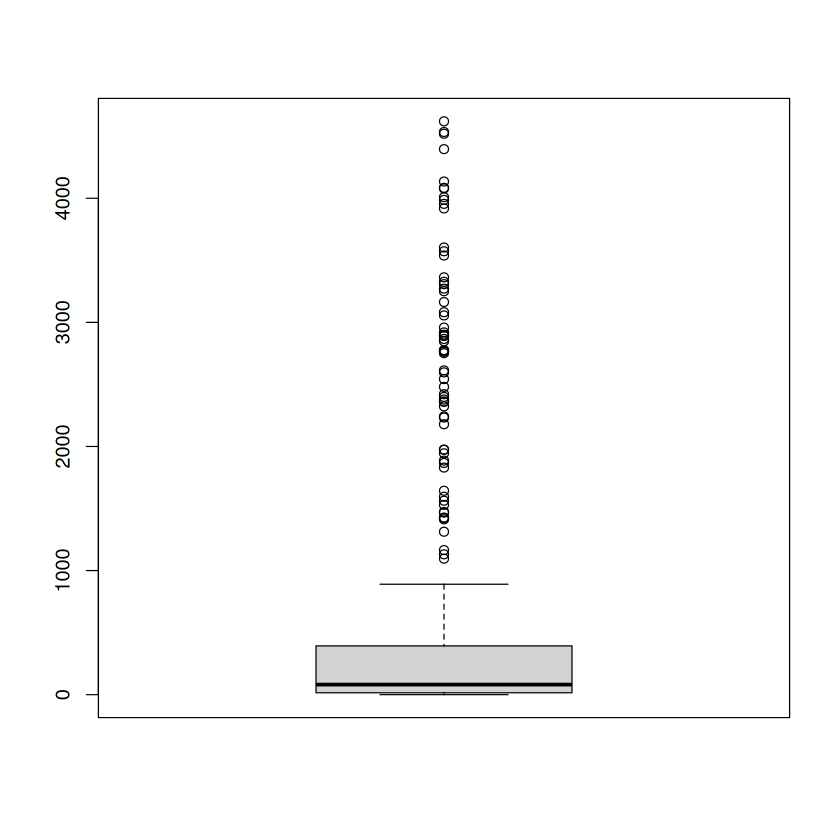

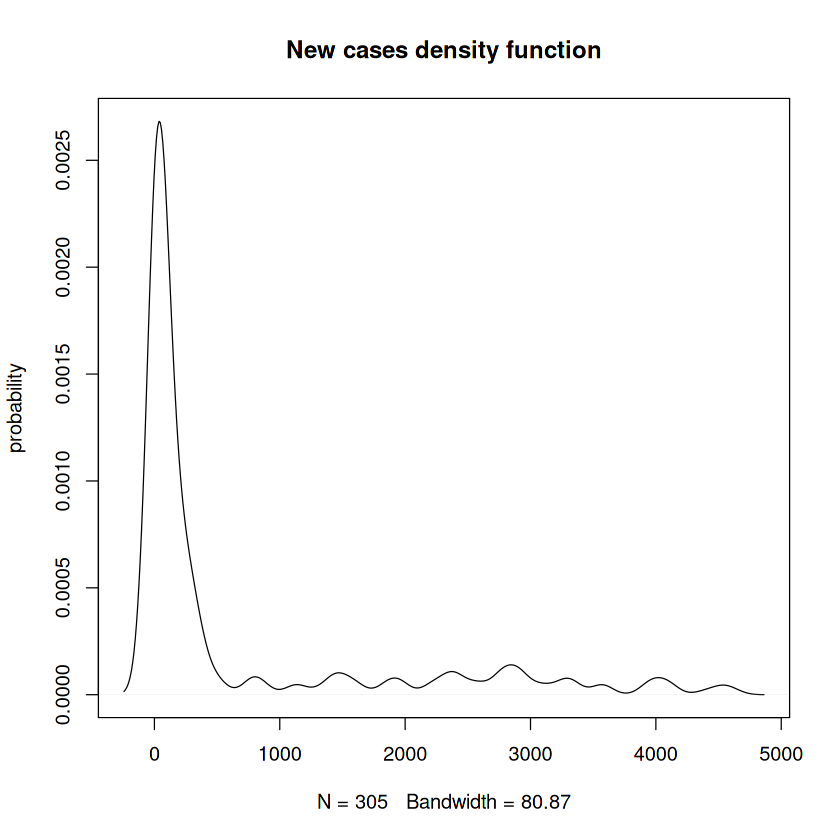

In [2]:
# Opisna statistička analiza
summary(data) # Kvartili, aritmetička srednja vrijednost
boxplot(data$new_cases) # Kutijasti dijagram za broj novih slučajeva
cat("Iznos varijance za broj zarazenih", var(data$new_cases), "\n")
cat("Iznos varijance za broj smrti", var(na.omit(data$new_deaths)), "\n")
cat("Iznos standardne devijacije za broj zarazenih", sd(data$new_cases), "\n")
cat("Iznos standardne devijacije za broj smrti", sd(na.omit(data$new_deaths)), "\n")
plot(density(data$new_cases), ylab="probability", main="New cases density function") # Funkcija vjerojatnosti za broj novozarazenih

In [3]:
# Podijela podataka na 80/20
smp_size <- floor(0.80 * nrow(data))
## set the seed to make your partition reproducible
set.seed(123)
train_ind <- sample(seq_len(nrow(data)), size = smp_size)
# 80% podataka
train <- data[train_ind, ]
# Sortiranje podataka nakon random podijele
train <- train[order(as.Date(train$dateRep, '%d-%m-%Y')),]
# 20% podataka
test <- data[-train_ind, ]
# Sortiranje podataka nakon random podijele
test <- test[order(as.Date(test$dateRep, '%d-%m-%Y')),]

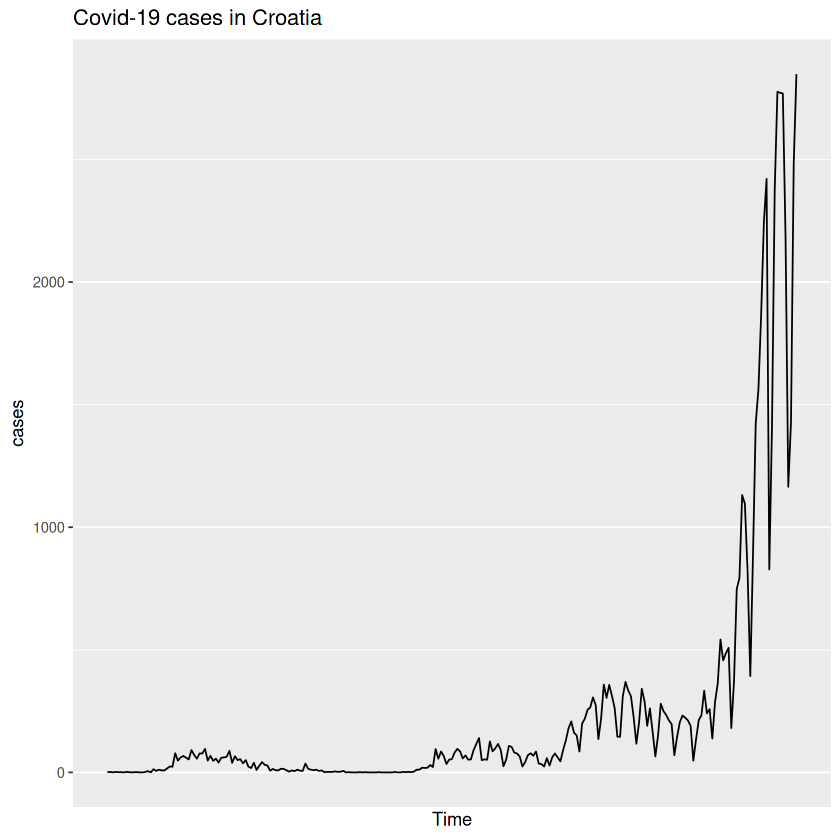

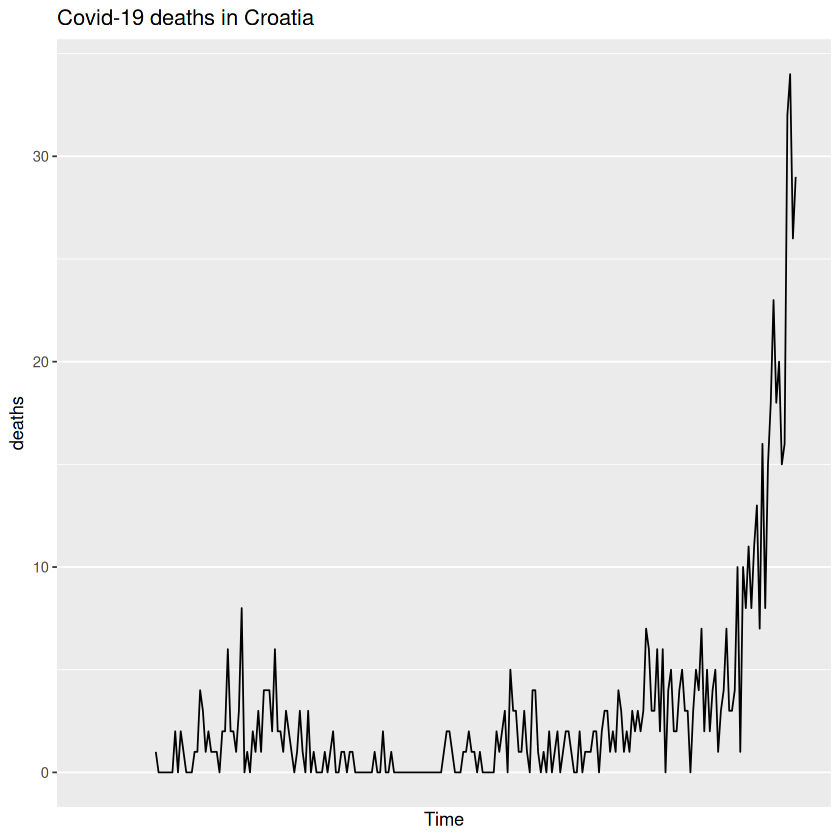

In [7]:
# Pretvorba u Time Series (u biti samo lista sa slucajevima po danima)
# potrebno da mozemo ubaciti u model
train_series <- ts(train_data[,c('new_cases', 'new_deaths')], start = c(2020, 56), end = c(2020, 310), frequency = 365) # Covid data started in February 25th (56th day in the year)
train_cases_series <- ts(train_data[,c('new_cases')], start = c(2020, 56), end = c(2020, 310), frequency = 365)
train_deaths_series <- ts(train_data[,c('new_deaths')], start = c(2020, 56), end = c(2020, 310), frequency = 365)
# Train data is until November 6th (310th day in the year)

test_series <- ts(test_data[,c('new_cases', 'new_deaths')], start = c(2020, 311), end = c(2020, 359), frequency = 365) # Data is until December 25th (359th day in the year)
autoplot(train_cases_series, ylab="cases", main="Covid-19 cases in Croatia")
autoplot(train_deaths_series, ylab="deaths", main="Covid-19 deaths in Croatia")

Sljedećim kodom promatramo postoji li sezonalnosti u podacima, zaključujemo da ne postoji

In [5]:
# Seasonal plot
seasplot(train_series)
seasplot(train_series, outplot =2)
y.dc <- decomp(train_series, outplot = 1)

ERROR: Error in if (min(y) <= 0) {: missing value where TRUE/FALSE needed


## Forecasts for future new cases

In [ ]:
## Simple Exponential Smoothing
se_model <- ses(train_series[,c(1)], h = 49) # "h =" argument decides for how many days it should predict
autoplot(se_model)
# Opisna statistička analiza reziduala
cat("Opisna statisticka analiza reziduala:\n")
res <- se_model$residuals
summary(res)
# Crtanje reziduala
plot(res)
# Histogram reziduala
gghistogram(res)
# ACF - Auto Correlation Function
ggAcf(res)

In [ ]:
# Accuracy (ME ,RMSE...)
library(ggplot2)
accuracy(se_model, test_series[,1])

# Usporedba predvidenih vrijednosti s onima iz test seta
p1 <- autoplot(se_model) +
  theme(legend.position = "bottom")
p2 <- autoplot(test_series[,1]) +
  autolayer(se_model, alpha = .5) +
  ggtitle("Predicted vs. actuals for the test data set")

gridExtra::grid.arrange(p1, p2, nrow = 1)

## Forecast for future new deaths

In [ ]:
## Simple Exponential Smoothing
se_model_deaths <- ses(train_series[,c(2)], h = 49) # "h =" argument decides for how many days it should predict
autoplot(se_model_deaths)
# Opisna statistička analiza reziduala
cat("Opisna statisticka analiza reziduala:\n")
res_d <- se_model_deaths$residuals
summary(res)
# Crtanje reziduala
plot(res_d)
# Histogram reziduala
gghistogram(res_d)
# ACF - Auto Correlation Function
ggAcf(res_d)

In [ ]:
# Accuracy (ME ,RMSE...)
library(ggplot2)
accuracy(se_model_deaths, test_series[,2])

# Usporedba predvidenih vrijednosti s onima iz test seta
p1 <- autoplot(se_model_deaths) +
  theme(legend.position = "bottom")
p2 <- autoplot(test_series[,2]) +
  autolayer(se_model_deaths, alpha = .5) +
  ggtitle("Predicted vs. actuals for the test data set")

gridExtra::grid.arrange(p1, p2, nrow = 1)